In [219]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from dynamic_routing_analysis import spike_utils
import npc_lims
import os

import matplotlib
import matplotlib.font_manager as fm

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
fm.FontProperties().set_family('arial')

%load_ext autoreload
%autoreload 2
# %matplotlib inline
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# select opto experiment to plot

# 728917_2024-10-04 - VGAT mouse, ORB inactivation
# 741611_2024-09-11, 741611_2024-09-12 - PV-Cre mouse, PL inactivation
# 748098_2024-10-28 - PV-Cre mouse, PL inactivation
# 762124_2024-12-02 - Chrimson in ORB 

In [ ]:
session_table_path=r"\\allen\programs\mindscope\workgroups\dynamicrouting\Ethan\CO decoding results\session_table_v0.265.csv"
session_table=pl.read_csv(session_table_path).to_pandas()

In [185]:
session_table.query("session_id=='728917_2024-10-04'")

,session_id,is_production,project,date,time,subject_id,subject_age_days,subject_sex,subject_genotype,implant,...,n_hits,n_contingent_rewards,n_responses,n_trials,is_first_block_aud,is_first_block_vis,is_engaged,is_good_behavior,is_bad_behavior,is_stage_5_passed
197,728917_2024-10-04,False,DynamicRouting,2024-10-04,11:50:09,728917,216,F,VGAT-ChR2-YFP/wt,None,...,0.0;0.0;0.0;0.0;0.0;0.0,0.0;0.0;0.0;0.0;0.0;0.0,0.0;0.0;0.0;0.0;0.0;0.0,92.0;91.0;94.0;93.0;90.0;91.0,False,True,False,False,False,True


In [186]:
session_id='728917_2024-10-04'
# session_id='741611_2024-09-11'
# session_id='762124_2024-12-02'

trials=pd.read_parquet(
    npc_lims.get_cache_path('trials',session_id)
)
units=pd.read_parquet(
    npc_lims.get_cache_path('units',session_id)
)
units=units.sort_values('peak_channel')

In [222]:
trials.columns

Index(['start_time', 'stop_time', 'quiescent_start_time',
       'quiescent_stop_time', 'stim_start_time', 'stim_stop_time',
       'opto_start_time', 'opto_stop_time', 'response_window_start_time',
       'response_window_stop_time', 'reward_time',
       'post_response_window_start_time', 'post_response_window_stop_time',
       'stim_name', 'block_index', 'rewarded_modality', 'trial_index',
       'trial_index_in_block', 'opto_wavelength', 'opto_location_bregma_x',
       'opto_location_bregma_y', 'opto_duration', 'opto_label', 'opto_power',
       'opto_stim_name', 'repeat_index', 'is_response', 'is_correct',
       'is_incorrect', 'is_hit', 'is_false_alarm', 'is_correct_reject',
       'is_miss', 'is_go', 'is_nogo', 'is_rewarded', 'is_noncontingent_reward',
       'is_contingent_reward', 'is_reward_scheduled', 'is_instruction',
       'is_aud_stim', 'is_vis_stim', 'is_catch', 'is_target', 'is_aud_target',
       'is_vis_target', 'is_nontarget', 'is_aud_nontarget', 'is_vis_nontarge

In [190]:
trials['opto_power'].unique()

array([nan, 5. , 1.5])

In [220]:
trials['opto_location_bregma_x'].unique()

array([ nan, -1.3])

In [192]:
trials['opto_label'].unique()

array(['', 'probe_5mW', 'probe_1mW', 'lateral_5mW', 'posterior_5mW',
       'lateral_1mW', 'posterior_1mW'], dtype=object)

In [193]:
units['electrode_group_name'].unique()

array(['probeB'], dtype=object)

In [194]:
np.nanmean((trials['opto_start_time']-trials['stim_start_time']).values)


-0.026153908064850434

In [ ]:
# units.sort_values('peak_channel')['peak_channel']
trials[['opto_label','opto_location_bregma_x','opto_location_bregma_y']].value_counts()


array([ nan, 2.25])

In [195]:
spikes_time_before=0.5
spikes_time_after=1.0
spikes_binsize=0.1
trial_da = spike_utils.make_neuron_time_trials_tensor(units, trials, spikes_time_before, spikes_time_after, spikes_binsize)

In [196]:
# trials[['opto_power','opto_label']].value_counts()
trials['opto_label'].unique()

array(['', 'probe_5mW', 'probe_1mW', 'lateral_5mW', 'posterior_5mW',
       'lateral_1mW', 'posterior_1mW'], dtype=object)

In [197]:
#calculate metrics for each unit

unit_opto_metrics={
    'unit_id':[],
    'structure':[],
    'probe':[],
    'peak_channel':[],
    'opto_power':[],
    'opto_cond':[],
    'baseline':[],
    'vis1':[],
    'vis2':[],
    'sound1':[],
    'sound2':[],
    'catch':[],
}

opto_labels=trials['opto_label'].unique()

baseline_time_start=-0.5
baseline_time_stop=-0.1
baseline_dur=baseline_time_stop-baseline_time_start
stim_time_start=0.1
stim_time_stop=0.5
stim_dur=stim_time_stop-stim_time_start

#in no opto, and each opto condition combination
#baseline firing rate, vis1 response rate, vis2 response rate, sound1 response rate, sound2 response rate

for uu,unit in units.iterrows():
    unit_id=unit['unit_id']

    #no opto trials
    opto_power=0
    opto_cond='no_opto'
    no_opto_trials=trials.query('~is_opto')
    baseline=trial_da.sel(
        unit_id=unit_id,trials=no_opto_trials['trial_index'].values
        ).sel(time=slice(baseline_time_start,baseline_time_stop)).mean()#/baseline_dur
    
    vis1_no_opto_trials=trials.query('~is_opto & (stim_name=="vis1")')
    vis1=trial_da.sel(
        unit_id=unit_id,trials=vis1_no_opto_trials['trial_index'].values
        ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
    vis2_no_opto_trials=trials.query('~is_opto & (stim_name=="vis2")')
    vis2=trial_da.sel(
        unit_id=unit_id,trials=vis2_no_opto_trials['trial_index'].values
        ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
    sound1_no_opto_trials=trials.query('~is_opto & (stim_name=="sound1")')
    sound1=trial_da.sel(
        unit_id=unit_id,trials=sound1_no_opto_trials['trial_index'].values
        ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
    sound2_no_opto_trials=trials.query('~is_opto & (stim_name=="sound2")')
    sound2=trial_da.sel(
        unit_id=unit_id,trials=sound2_no_opto_trials['trial_index'].values
        ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
    catch=trial_da.sel(
        unit_id=unit_id,trials=no_opto_trials.query('stim_name=="catch"')['trial_index'].values
        ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur

    
    unit_opto_metrics['unit_id'].append(unit_id)
    unit_opto_metrics['structure'].append(unit['structure'])
    unit_opto_metrics['probe'].append(unit['electrode_group_name'])
    unit_opto_metrics['peak_channel'].append(unit['peak_channel'])
    unit_opto_metrics['opto_power'].append(opto_power)
    unit_opto_metrics['opto_cond'].append(opto_cond)
    unit_opto_metrics['baseline'].append(baseline.values)
    unit_opto_metrics['vis1'].append(vis1.values)
    unit_opto_metrics['vis2'].append(vis2.values)
    unit_opto_metrics['sound1'].append(sound1.values)
    unit_opto_metrics['sound2'].append(sound2.values)
    unit_opto_metrics['catch'].append(catch.values)

    #loop through opto conditions
    for opto_cond in opto_labels:
        if opto_cond=='':
            continue
        opto_power=trials.query(f'opto_label=="{opto_cond}"')['opto_power'].iloc[0]
        opto_trials=trials.query(f'is_opto & (opto_label=="{opto_cond}")')
        
        #baseline firing rate, vis1 response rate, vis2 response rate, sound1 response rate, sound2 response rate
        baseline=trial_da.sel(
            unit_id=unit_id,trials=opto_trials['trial_index'].values
            ).sel(time=slice(baseline_time_start,baseline_time_stop)).mean()#/baseline_dur
        vis1_opto_trials=trials.query(f'is_opto & (stim_name=="vis1") & (opto_label=="{opto_cond}")')
        vis1=trial_da.sel(
            unit_id=unit_id,trials=vis1_opto_trials['trial_index'].values
            ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
        vis2_opto_trials=trials.query(f'is_opto & (stim_name=="vis2") & (opto_label=="{opto_cond}")')
        vis2=trial_da.sel(
            unit_id=unit_id,trials=vis2_opto_trials['trial_index'].values
            ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
        sound1_opto_trials=trials.query(f'is_opto & (stim_name=="sound1") & (opto_label=="{opto_cond}")')
        sound1=trial_da.sel(
            unit_id=unit_id,trials=sound1_opto_trials['trial_index'].values
            ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
        sound2_opto_trials=trials.query(f'is_opto & (stim_name=="sound2") & (opto_label=="{opto_cond}")')
        sound2=trial_da.sel(
            unit_id=unit_id,trials=sound2_opto_trials['trial_index'].values
            ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
        catch=trial_da.sel(
            unit_id=unit_id,trials=opto_trials.query('stim_name=="catch"')['trial_index'].values
            ).sel(time=slice(stim_time_start,stim_time_stop)).mean()#/stim_dur
        
        unit_opto_metrics['unit_id'].append(unit_id)
        unit_opto_metrics['structure'].append(unit['structure'])
        unit_opto_metrics['probe'].append(unit['electrode_group_name'])
        unit_opto_metrics['peak_channel'].append(unit['peak_channel'])
        unit_opto_metrics['opto_power'].append(opto_power)
        unit_opto_metrics['opto_cond'].append(opto_cond)
        unit_opto_metrics['baseline'].append(baseline.values)
        unit_opto_metrics['vis1'].append(vis1.values)
        unit_opto_metrics['vis2'].append(vis2.values)
        unit_opto_metrics['sound1'].append(sound1.values)
        unit_opto_metrics['sound2'].append(sound2.values)
        unit_opto_metrics['catch'].append(catch.values)

unit_opto_metrics_df=pd.DataFrame(unit_opto_metrics)


In [198]:
unit_opto_metrics_df

,unit_id,structure,probe,peak_channel,opto_power,opto_cond,baseline,vis1,vis2,sound1,sound2,catch
0,728917_2024-10-04_B-0,AON,probeB,1,0.0,no_opto,0.08152173913043478,0.24305555555555555,0.20833333333333334,0.09868421052631579,0.2631578947368421,0.0
1,728917_2024-10-04_B-0,AON,probeB,1,5.0,probe_5mW,0.19607843137254902,0.0,0.2777777777777778,0.25,0.0,0.22727272727272727
2,728917_2024-10-04_B-0,AON,probeB,1,1.5,probe_1mW,0.1111111111111111,0.0,1.1111111111111112,0.0,0.0,0.0
3,728917_2024-10-04_B-0,AON,probeB,1,5.0,lateral_5mW,0.0,0.0,0.625,0.0,0.0,0.0
4,728917_2024-10-04_B-0,AON,probeB,1,5.0,posterior_5mW,0.17857142857142858,0.3125,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4573,728917_2024-10-04_B-320,out of brain,probeB,371,1.5,probe_1mW,0.4444444444444444,0.5,0.0,0.0,0.0,4.444444444444445
4574,728917_2024-10-04_B-320,out of brain,probeB,371,5.0,lateral_5mW,0.17045454545454544,0.35714285714285715,0.0,0.0,0.0,0.0
4575,728917_2024-10-04_B-320,out of brain,probeB,371,5.0,posterior_5mW,0.11904761904761904,0.0,0.0,0.0,0.0,0.0
4576,728917_2024-10-04_B-320,out of brain,probeB,371,1.5,lateral_1mW,1.09375,1.1111111111111112,1.5,0.5,1.6666666666666667,28.25


In [111]:
# unit_opto_metrics_df.query('unit_id=="728917_2024-10-04_B-193"')

In [ ]:
# sel_unit_to_plot='728917_2024-10-04_B-320'
savepath=r"C:\Users\ethan.mcbride\OneDrive - Allen Institute\quick figures\2025-05-01-opto_perturb_plots\psths"

sel_units_to_plot=units.query('isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7 and \
                                activity_drift<=0.2 and decoder_label!="noise" and firing_rate>=2.0')['unit_id'].values

opto_labels=trials['opto_label'].unique()


for unit_id in sel_units_to_plot:
    # unit=unit_opto_metrics_df.query(f'unit_id=="{unit_id}"')
    unit_PSTHs={
        'unit_id':[],
        'opto_cond':[],
        'stim_name':[],
        'time':[],
        'PSTH':[]
    }
    for opto_cond in opto_labels:
        for stim_name in ['vis1','vis2','sound1','sound2','catch']:
            if opto_cond=='' or opto_cond=='no_opto':
                opto_cond='no_opto'
                trials_opto=trials.query('~is_opto and (stim_name==@stim_name)')
            else:
                trials_opto=trials.query(f'opto_label=="{opto_cond}" and (stim_name==@stim_name)')

            # unit_id=sel_unit_to_plot
            unit_PSTH=trial_da.sel(unit_id=unit_id).sel(trials=trials_opto['trial_index'].values).mean(dim='trials')

            # trials_non_opto=trials.query('~is_opto and (stim_name==@stim_name)').values
            # baseline_fr=trial_da.sel(unit_id=unit_id,time=slice(-0.2,0),trials=trials_non_opto).mean(dim='time')
            # stimulus_fr=trial_da.sel(unit_id=unit_id,time=slice(0,0.2),trials=trials_non_opto).mean(dim='time')

            # _,stim_mod_p=stats.wilcoxon(stimulus_fr.values.flatten(),baseline_fr.values.flatten())

            unit_PSTHs['unit_id'].append(unit_id)
            unit_PSTHs['opto_cond'].append(opto_cond)
            unit_PSTHs['stim_name'].append(stim_name)
            unit_PSTHs['time'].append(unit_PSTH.time.values)
            unit_PSTHs['PSTH'].append(unit_PSTH.values)

    unit_PSTHs_df=pd.DataFrame(unit_PSTHs)

    fig,ax=plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True)
    ax=ax.flatten()

    for ss,stim_name in enumerate(['vis1','vis2','sound1','sound2','catch']):

        ax[ss].axvline(0,color='k',linestyle='--',linewidth=0.5)
        ax[ss].axvline(0.5,color='k',linestyle='--',linewidth=0.5)

        for opto_cond in opto_labels:
            if opto_cond=='':
                opto_cond='no_opto'
                color='k'
            elif opto_cond=='no_opto':
                color='k'
            elif opto_cond=='probe_1mW':
                color='lightskyblue'
            elif opto_cond=='probe_5mW':
                color='royalblue'
            else:
                continue
            unit_PSTH=unit_PSTHs_df.query(f'opto_cond=="{opto_cond}" and stim_name==@stim_name')['PSTH'].values[0]
            unit_PSTH_time=unit_PSTHs_df.query(f'opto_cond=="{opto_cond}" and stim_name==@stim_name')['time'].values[0]
            ax[ss].plot(unit_PSTH_time,unit_PSTH,color=color,label=opto_cond)

        # ax.legend()
        ax[ss].set_xlabel('Time relative to stimulus (s)')
        ax[ss].set_ylabel('Firing rate (Hz)')
        ax[ss].set_title(stim_name)

    fig.suptitle(f"{unit_id}; {units.query('unit_id==@unit_id')['structure'].values[0]}; ch {units.query('unit_id==@unit_id')['peak_channel'].values[0]}")

    fig.tight_layout()

    fig.savefig(os.path.join(savepath,f"{unit_id}.png"),dpi=300)
    plt.close(fig)

    # break

In [87]:
units.query('isi_violations_ratio<=0.5 and amplitude_cutoff<=0.1 and presence_ratio>=0.7 and \
            activity_drift<=0.2 and decoder_label!="noise" and firing_rate>=1.0').shape

(257, 61)

In [ ]:
units.query(f'unit_id=="{unit_id}"')['structure']
units.query(f'unit_id=="{unit_id}"')['peak_channel']

,activity_drift,amplitude,amplitude_cutoff,amplitude_cv_median,amplitude_cv_range,amplitude_median,ccf_ap,ccf_dv,ccf_ml,channels,...,unit_id,velocity_above,velocity_below,spike_times,obs_intervals,electrodes,session_idx,date,subject_id,session_id
id,,,,,,,,,,,,,,,,,,,,,
309,0.017,85.264935,0.002052,NaN,NaN,46.8,NaN,NaN,NaN,"[358, 359, 360, 361, 362, 364, 365, 366, 367, ...",...,728917_2024-10-04_B-320,NaN,NaN,"[28.819634362063137, 29.085600060700422, 39.85...","[[24.2649842728541, 3688.0]]","[358, 359, 360, 361, 362, 364, 365, 366, 367, ...",0,2024-10-04,728917,728917_2024-10-04


In [212]:
sel_opto_cond="lateral_5mW"
# sel_opto_cond='PL 2.0 '
sel_probe='probeB'

norm_unit_opto_metrics={
    'unit_id':[],
    'structure':[],
    'peak_channel':[],
    'opto_power':[],
    'opto_cond':[],
    'baseline':[],
    'vis1':[],
    'vis2':[],
    'sound1':[],
    'sound2':[],
    'catch':[],
}

for unit_id in unit_opto_metrics_df.query('probe==@sel_probe')['unit_id'].unique():
    unit=unit_opto_metrics_df.query(f'unit_id=="{unit_id}"')

    unit_baseline=unit.query('opto_cond=="no_opto"')['baseline'].values[0]
    unit_vis1=unit.query('opto_cond=="no_opto"')['vis1'].values[0]
    unit_vis2=unit.query('opto_cond=="no_opto"')['vis2'].values[0]
    unit_sound1=unit.query('opto_cond=="no_opto"')['sound1'].values[0]
    unit_sound2=unit.query('opto_cond=="no_opto"')['sound2'].values[0]
    unit_catch=unit.query('opto_cond=="no_opto"')['catch'].values[0]

    opto_power=trials.query(f'opto_label=="{sel_opto_cond}"')['opto_power'].iloc[0]

    norm_unit_opto_metrics['unit_id'].append(unit_id)
    norm_unit_opto_metrics['structure'].append(unit['structure'].values[0])
    norm_unit_opto_metrics['peak_channel'].append(unit['peak_channel'].values[0])
    norm_unit_opto_metrics['opto_power'].append(opto_power)
    norm_unit_opto_metrics['opto_cond'].append(sel_opto_cond)
    norm_unit_opto_metrics['baseline'].append((unit.query(f'opto_cond==@sel_opto_cond')['baseline'].values[0]-unit_baseline)/
                                              (unit.query(f'opto_cond==@sel_opto_cond')['baseline'].values[0]+unit_baseline))
    norm_unit_opto_metrics['vis1'].append((unit.query(f'opto_cond==@sel_opto_cond')['vis1'].values[0]-unit_vis1)/
                                          (unit.query(f'opto_cond==@sel_opto_cond')['vis1'].values[0]+unit_vis1))
    norm_unit_opto_metrics['vis2'].append((unit.query(f'opto_cond==@sel_opto_cond')['vis2'].values[0]-unit_vis2)/
                                          (unit.query(f'opto_cond==@sel_opto_cond')['vis2'].values[0]+unit_vis2))
    norm_unit_opto_metrics['sound1'].append((unit.query(f'opto_cond==@sel_opto_cond')['sound1'].values[0]-unit_sound1)/
                                            (unit.query(f'opto_cond==@sel_opto_cond')['sound1'].values[0]+unit_sound1))
    norm_unit_opto_metrics['sound2'].append((unit.query(f'opto_cond==@sel_opto_cond')['sound2'].values[0]-unit_sound2)/
                                            (unit.query(f'opto_cond==@sel_opto_cond')['sound2'].values[0]+unit_sound2))
    norm_unit_opto_metrics['catch'].append((unit.query(f'opto_cond==@sel_opto_cond')['catch'].values[0]-unit_catch)/
                                           (unit.query(f'opto_cond==@sel_opto_cond')['catch'].values[0]+unit_catch))

norm_unit_opto_metrics_df=pd.DataFrame(norm_unit_opto_metrics)
    

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11308\3639614500.py:46: RuntimeWarning: invalid value encountered in scalar divide
  norm_unit_opto_metrics['catch'].append((unit.query(f'opto_cond==@sel_opto_cond')['catch'].values[0]-unit_catch)/
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11308\3639614500.py:40: RuntimeWarning: invalid value encountered in scalar divide
  norm_unit_opto_metrics['vis2'].append((unit.query(f'opto_cond==@sel_opto_cond')['vis2'].values[0]-unit_vis2)/
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11308\3639614500.py:42: RuntimeWarning: invalid value encountered in scalar divide
  norm_unit_opto_metrics['sound1'].append((unit.query(f'opto_cond==@sel_opto_cond')['sound1'].values[0]-unit_sound1)/
C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11308\3639614500.py:44: RuntimeWarning: invalid value encountered in scalar divide
  norm_unit_opto_metrics['sound2'].append((unit.query(f'opto_cond==@sel_opto_cond')['sound2'].values[0]-unit_sound2

(array([271.,  44.,  72.,  76.,  62.,  50.,  19.,   4.,   5.,   9.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

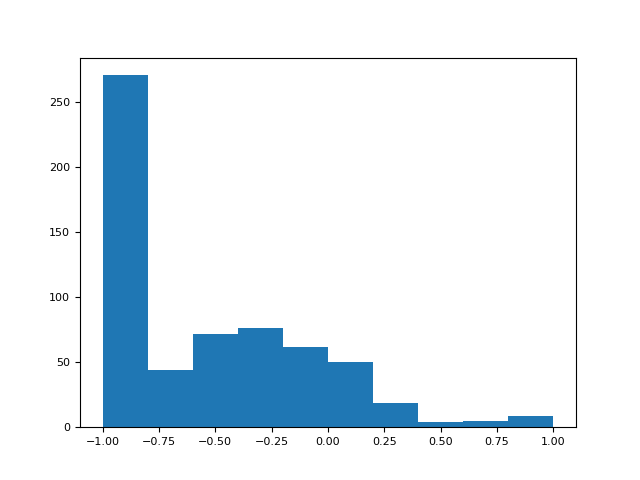

In [213]:
fig,ax=plt.subplots(1,1)
ax.hist(norm_unit_opto_metrics_df['vis1'].values)

In [201]:
norm_unit_opto_metrics_df

,unit_id,structure,peak_channel,opto_power,opto_cond,baseline,vis1,vis2,sound1,sound2,catch
0,728917_2024-10-04_B-0,AON,1,5.0,posterior_5mW,0.373134,0.125000,-1.000000,-1.000000,-1.000000,NaN
1,728917_2024-10-04_B-1,AON,1,5.0,posterior_5mW,-0.036868,-0.141188,0.002950,0.003383,0.037423,-0.095890
2,728917_2024-10-04_B-322,AON,1,5.0,posterior_5mW,-0.044010,0.000000,0.239669,0.321739,-0.095238,0.392405
3,728917_2024-10-04_B-15,AON,1,5.0,posterior_5mW,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
4,728917_2024-10-04_B-2,AON,3,5.0,posterior_5mW,-0.041110,-0.195426,-0.115365,-0.194580,-0.151786,0.107914
...,...,...,...,...,...,...,...,...,...,...,...
649,728917_2024-10-04_B-327,out of brain,358,5.0,posterior_5mW,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
650,728917_2024-10-04_B-666,out of brain,358,5.0,posterior_5mW,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
651,728917_2024-10-04_B-545,out of brain,358,5.0,posterior_5mW,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
652,728917_2024-10-04_B-645,out of brain,371,5.0,posterior_5mW,-1.000000,-1.000000,-1.000000,-1.000000,NaN,NaN


In [120]:
# norm_unit_opto_metrics_df.query('unit_id=="728917_2024-10-04_B-194"')

In [121]:
# channel_bin_size=10
# channel_bins=np.arange(0,384,channel_bin_size)

# ch=100
# ch_bin_units=norm_unit_opto_metrics_df.query(f'peak_channel>={ch} and peak_channel<{ch+channel_bin_size}')
# ch_bin_units

In [215]:
sel_stim='vis1'
sel_opto_cond='lateral_5mW'
# sel_opto_cond='ORB 4.0'
# sel_opto_cond='PL 2.0 '
channel_bin_size=20
channel_bins=np.arange(0,384,channel_bin_size)

putative_inh_vect=[]
opto_effect_vect=[]

#loop over channel bins
for ch in channel_bins:
    ch_bin_units=norm_unit_opto_metrics_df.query('peak_channel>=@ch and peak_channel<(@ch+@channel_bin_size) and structure!="out of brain"')

    putative_inh=ch_bin_units.query(f'opto_cond==@sel_opto_cond and {sel_stim} > 0')[sel_stim].mean()
    putative_inh_vect.append(putative_inh)

    opto_effect=ch_bin_units.query(f'opto_cond==@sel_opto_cond and {sel_stim} <= 0')[sel_stim].mean()
    opto_effect_vect.append(opto_effect)


#find units in each channel bin

#take response fraction - sel_opto_cond / no_opto for baseline and each stimulus

In [216]:
#get structure edges
unique_structures=units.query('electrode_group_name==@sel_probe')['structure'].unique()

structure_channel_ranges={
    'structure':[],
    'channel_min':[],
    'channel_max':[],
    'channel_mid':[],
}

for ss in unique_structures:
    structure_channel_ranges['structure'].append(ss)
    structure_channel_ranges['channel_min'].append(units.query('structure==@ss and electrode_group_name==@sel_probe')['peak_channel'].min())
    structure_channel_ranges['channel_max'].append(units.query('structure==@ss and electrode_group_name==@sel_probe')['peak_channel'].max())
    structure_channel_ranges['channel_mid'].append((units.query('structure==@ss and electrode_group_name==@sel_probe')['peak_channel'].min()+
                                                    units.query('structure==@ss and electrode_group_name==@sel_probe')['peak_channel'].max())/2)
    
structure_channel_ranges_df=pd.DataFrame(structure_channel_ranges)
structure_channel_ranges_df

,structure,channel_min,channel_max,channel_mid
0,AON,1,16,8.5
1,OLF,34,49,41.5
2,ORBl,79,158,118.5
3,FRP,159,201,180.0
4,MOs,202,251,226.5
5,out of brain,282,371,326.5


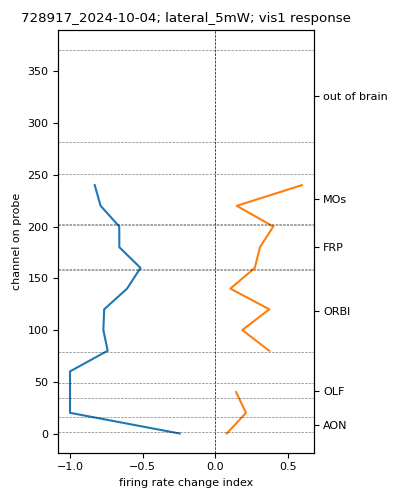

In [217]:
fig,ax=plt.subplots(1,1,figsize=(4,5))

ax.axvline(0,color='k',linestyle='--',linewidth=0.5)
ax.plot(opto_effect_vect,channel_bins)
ax.plot(putative_inh_vect,channel_bins)

#structure labels on the right
for ss,structure in enumerate(structure_channel_ranges_df['structure'].values):
    ax.axhline(structure_channel_ranges_df['channel_min'].values[ss],color='k',linestyle='--',linewidth=0.5,alpha=0.5)
    ax.axhline(structure_channel_ranges_df['channel_max'].values[ss],color='k',linestyle='--',linewidth=0.5,alpha=0.5)

#right side axis
ax2=ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(structure_channel_ranges_df['channel_mid'].values)
ax2.set_yticklabels(structure_channel_ranges_df['structure'].values,rotation=0,ha='left',fontsize=8)

ax.set_xlabel('firing rate change index')
ax.set_ylabel('channel on probe')
ax.set_title(f"{session_id}; {sel_opto_cond}; {sel_stim} response")

fig.tight_layout()

C:\Users\ethan.mcbride\AppData\Local\Temp\ipykernel_11308\30102648.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


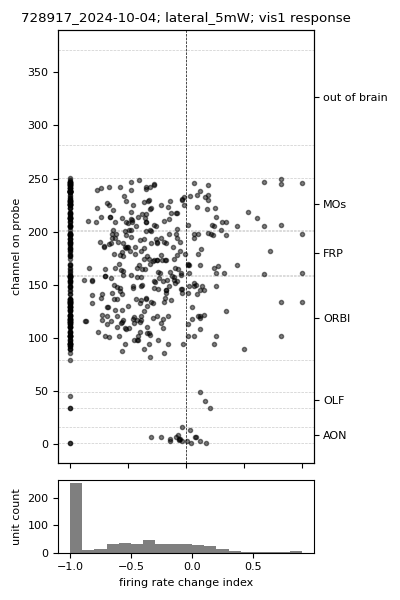

In [218]:
#just plot all units 
#gridspec
import matplotlib.gridspec as gridspec

fig = plt.figure(layout="constrained",figsize=(4, 6))
gs = gridspec.GridSpec(6, 1)

ax=plt.subplot(gs[0:5, 0])

# fig,ax=plt.subplots(2,1,figsize=(3,6))
ax.axvline(0,color='k',linestyle='--',linewidth=0.5)

ax.plot(norm_unit_opto_metrics_df.query(f'opto_cond==@sel_opto_cond and structure!="out of brain"')[sel_stim].values,
        norm_unit_opto_metrics_df.query(f'opto_cond==@sel_opto_cond and structure!="out of brain"')['peak_channel'].values,
        '.',color='black',alpha=0.5)

ax.set_xticklabels([])
ax.set_ylabel('channel on probe')

ax.set_title(f"{session_id}; {sel_opto_cond}; {sel_stim} response")

#structure labels on the right
for ss,structure in enumerate(structure_channel_ranges_df['structure'].values):
    ax.axhline(structure_channel_ranges_df['channel_min'].values[ss],color='k',linestyle='--',linewidth=0.5,alpha=0.2)
    ax.axhline(structure_channel_ranges_df['channel_max'].values[ss],color='k',linestyle='--',linewidth=0.5,alpha=0.2)

#right side axis
ax2=ax.twinx()
ax2.set_ylim(ax.get_ylim())
ax2.set_yticks(structure_channel_ranges_df['channel_mid'].values)
ax2.set_yticklabels(structure_channel_ranges_df['structure'].values,rotation=0,ha='left',fontsize=8)


ax=plt.subplot(gs[5, 0])
ax.hist(norm_unit_opto_metrics_df.query(f'opto_cond==@sel_opto_cond and structure!="out of brain"')[sel_stim].values,
        bins=np.arange(-1,1,0.1),color='black',alpha=0.5)

ax.set_xlabel('firing rate change index')
ax.set_ylabel('unit count')



fig.tight_layout()

In [56]:
#plot baseline & stimulus evoked activty with and without opto across the whole probe?



In [223]:
import h5py

In [246]:
# path = r"D:\DynamicRouting1_728917_20241004_104710.hdf5"
path= r"D:\DynamicRouting1_762124_20241202_150618.hdf5"

f=h5py.File(path,'r')

list(f.keys())

['acquisitionSignalLine',
 'ampModFreq',
 'autoRewardMissTrials',
 'autoRewardOnsetFrame',
 'behavNidaqDevice',
 'behavNidaqDeviceSerialNum',
 'blockCatchProb',
 'blockStim',
 'blockStimProb',
 'blockStimRewarded',
 'bregmaGalvoCalibrationData',
 'computerName',
 'configPath',
 'customSampling',
 'deltaWheelPos',
 'digitalSolenoidTrigger',
 'diodeBoxPosition',
 'diodeBoxSize',
 'drawDiodeBox',
 'evenSampling',
 'firstBlockNogoStim',
 'frameIntervals',
 'frameRate',
 'frameSignalLine',
 'framesPerBlock',
 'galvoChannels',
 'galvoDwellTime',
 'galvoX',
 'galvoY',
 'gammaErrorPolicy',
 'githubTaskScript',
 'gratingEdge',
 'gratingEdgeBlurWidth',
 'gratingOri',
 'gratingPhase',
 'gratingSF',
 'gratingSize',
 'gratingTF',
 'gratingType',
 'importOptoParams',
 'incorrectSound',
 'incorrectSoundDur',
 'incorrectSoundFreq',
 'incorrectSoundLevel',
 'incorrectSoundVolume',
 'incorrectTimeoutColor',
 'incorrectTimeoutFrames',
 'incorrectTrialRepeats',
 'lastFrame',
 'lickDetectorFrames',
 'lickF

In [247]:
f['optoParams'].keys()

<KeysViewHDF5 ['bregma offset X', 'bregma offset Y', 'bregmaX', 'bregmaY', 'delay', 'device', 'duration', 'dwell time', 'frequency', 'galvoX', 'galvoY', 'label', 'off ramp', 'on ramp', 'onset frame', 'optoVoltage', 'power', 'probability']>

In [248]:
xy_coords=np.concatenate([f['optoParams']['bregmaX'][:],f['optoParams']['bregmaY'][:]],axis=1)
xy_coords

array([[-0.4,  2.5],
       [-0.4,  2.5],
       [-0.4,  2.5],
       [-0.4,  2.5],
       [-0.4,  2.5]])

In [249]:
f['optoParams']['label'][:]

array([b'PL 0.1 ', b'PL 0.25 ', b'PL 0.5 ', b'PL 1.0 ', b'PL 2.0 '],
      dtype=object)